<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#mlp-regression" data-toc-modified-id="mlp-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>mlp regression</a></span><ul class="toc-item"><li><span><a href="#regularization-&amp;-hyperparameters-tuning" data-toc-modified-id="regularization-&amp;-hyperparameters-tuning-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>regularization &amp; hyperparameters tuning</a></span></li></ul></li><li><span><a href="#pinn" data-toc-modified-id="pinn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>pinn</a></span></li></ul></div>

# tl;dr

In this notebook we will try to write code for a PINN that solves the Damped Harmonic Oscillator problem. We will not use the parameter learning approach. Instead, we will use a MLP to learn the solution of the DHO problem. Then, we turn the MLP in a PINN by adding the DHO ODE as a loss function.

The goal here is not to get the best results, but to get a working code that we can use as a starting point for the parameter learning approach.

# setup

In [1]:
import pprint
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

# data

<!-- **medidas** <br/> de [Lab 6: Simple Harmonic Oscillators](https://www.studocu.com/en-us/document/the-city-college-of-new-york/general-physics-i/lab-6-simple-harmonic-oscillators/27226380)

| $Time(s)$ | $Position (m)$ | $Velocity (m s^{-1})$ | Acceleration ($m s^{-2}$) |
|:-----------:|:---------------:|:-----------------:|:-----------------------:|
|      0      |     0.181104    |     -0.003521     |        0.0107877        |
|     0.5     |    0.1808296    |      -0.00048     |        -0.016009        |
|      1      |    0.1808296    |     0.0563435     |        0.9898961        |
|     1.5     |    0.2458624    |     0.0782269     |         1.068586        |
|      2      |     0.208544    |     -0.279888     |         0.698207        |
|     2.5     |    0.1808296    |     0.0872821     |        1.2009078        |
|      3      |     0.297724    |     0.0721215     |         -1.22394        |

Spring Constant: k = 16.16
Length of Spring: 0.18m
Length of Spring (Stretched): 0.787m
X= 0.607 

data = [
    [0, 0.181104, -0.003521, 0.0107877],
    [0.5, 0.1808296, -0.00048, -0.016009],
    [1, 0.1808296, 0.0563435, 0.9898961],
    [1.5, 0.2458624, 0.0782269, 1.068586],
    [2, 0.208544, -0.279888, 0.698207],
    [2.5, 0.1808296, 0.0872821, 1.2009078],
    [3, 0.297724, 0.0721215, -1.22394]
]

pd.DataFrame(data, columns=["t", "x", "v", "a"])
-->

**medidas** <br/> [Damped Harmonic Oscillator Dataset by Cecília Coelho](https://www.kaggle.com/datasets/cici118/damped-harmonic-oscillator)

* $m = 1kg$
* $k = 1 N m^{-1}$
* $\mu = 0.1 N s m^{-1}$
* $x_0 = 1 m$
* $v_0 = 0 m s^{-1}$

,time,displacement,velocity,acceleration
0,0.000000,1.000000,0.000000,-1.000000
1,0.030303,0.106701,-0.926586,-0.014042
2,0.060606,-0.847175,-0.111879,0.858363
3,0.090909,-0.194060,0.783410,0.115719
4,0.121212,0.705190,0.190814,-0.724272
5,0.151515,0.252050,-0.650740,-0.186976
6,0.181818,-0.576071,-0.242684,0.600339
7,0.212121,-0.286335,0.530372,0.233298
8,0.242424,0.460883,0.272761,-0.488160
9,0.272727,0.301914,-0.423218,-0.259593


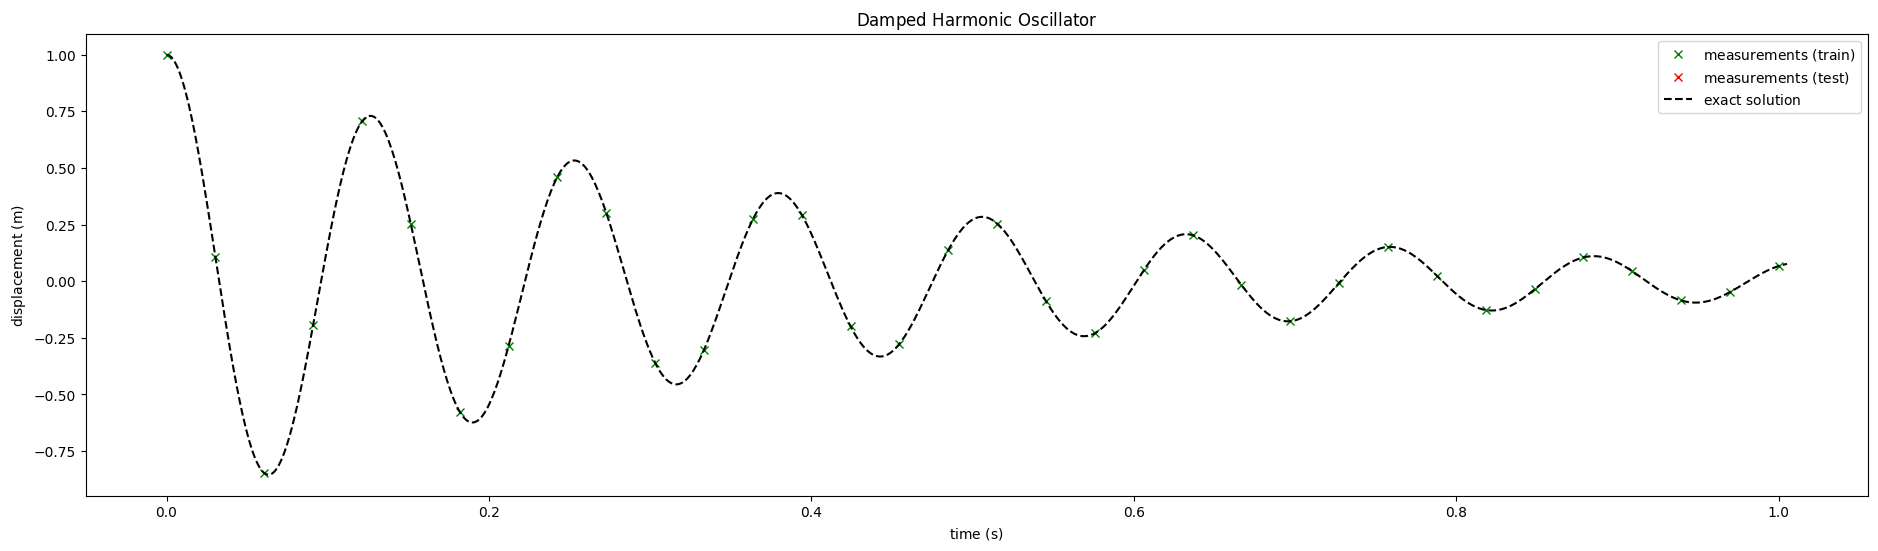

In [10]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")

min_max_scaler = MinMaxScaler()
X["time"] = min_max_scaler.fit_transform(X["time"].values.reshape(-1, 1))

display(X)

# plot experimental data
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 50").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    min_max_scaler.transform(t.reshape(-1, 1)), 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico.png", dpi=300, bbox_inches="tight") ;

In [11]:
x_train = torch.tensor(X.query("time <= 30")["time"].values).float().unsqueeze(1)
y_train = torch.tensor(X.query("time <= 30")["displacement"].values).float().unsqueeze(1)

x_test = torch.tensor(X.query("time > 30 and time <= 50")["time"].values).float().unsqueeze(1)
y_test = torch.tensor(X.query("time > 30 and time <= 50")["displacement"].values).float().unsqueeze(1)

# mlp regression

In [12]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33)

learning_rate = 0.001
num_epochs = 500

model = MultiLayerPerceptronRegressor([1] + [16 for _ in range(8)] + [1], nn.ReLU)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

plot_loss_train = dict(epoch=[], loss=[])

for epoch in range(num_epochs):
    # forward
    y_train_hat = model(x_train)
    loss = criterion(y_train_hat, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["loss"].append(loss.item())


epoch [00010/00500] loss: 0.1186
epoch [00020/00500] loss: 0.1125
epoch [00030/00500] loss: 0.1129
epoch [00040/00500] loss: 0.1126
epoch [00050/00500] loss: 0.1124
epoch [00060/00500] loss: 0.1124
epoch [00070/00500] loss: 0.1123
epoch [00080/00500] loss: 0.1123
epoch [00090/00500] loss: 0.1123
epoch [00100/00500] loss: 0.1122
epoch [00110/00500] loss: 0.1121
epoch [00120/00500] loss: 0.1119
epoch [00130/00500] loss: 0.1116
epoch [00140/00500] loss: 0.1114
epoch [00150/00500] loss: 0.1111
epoch [00160/00500] loss: 0.1108
epoch [00170/00500] loss: 0.1105
epoch [00180/00500] loss: 0.1097
epoch [00190/00500] loss: 0.1087
epoch [00200/00500] loss: 0.1072
epoch [00210/00500] loss: 0.1058
epoch [00220/00500] loss: 0.1043
epoch [00230/00500] loss: 0.1017
epoch [00240/00500] loss: 0.0988
epoch [00250/00500] loss: 0.095
epoch [00260/00500] loss: 0.0916
epoch [00270/00500] loss: 0.0874
epoch [00280/00500] loss: 0.0842
epoch [00290/00500] loss: 0.0826
epoch [00300/00500] loss: 0.0818
epoch [0031

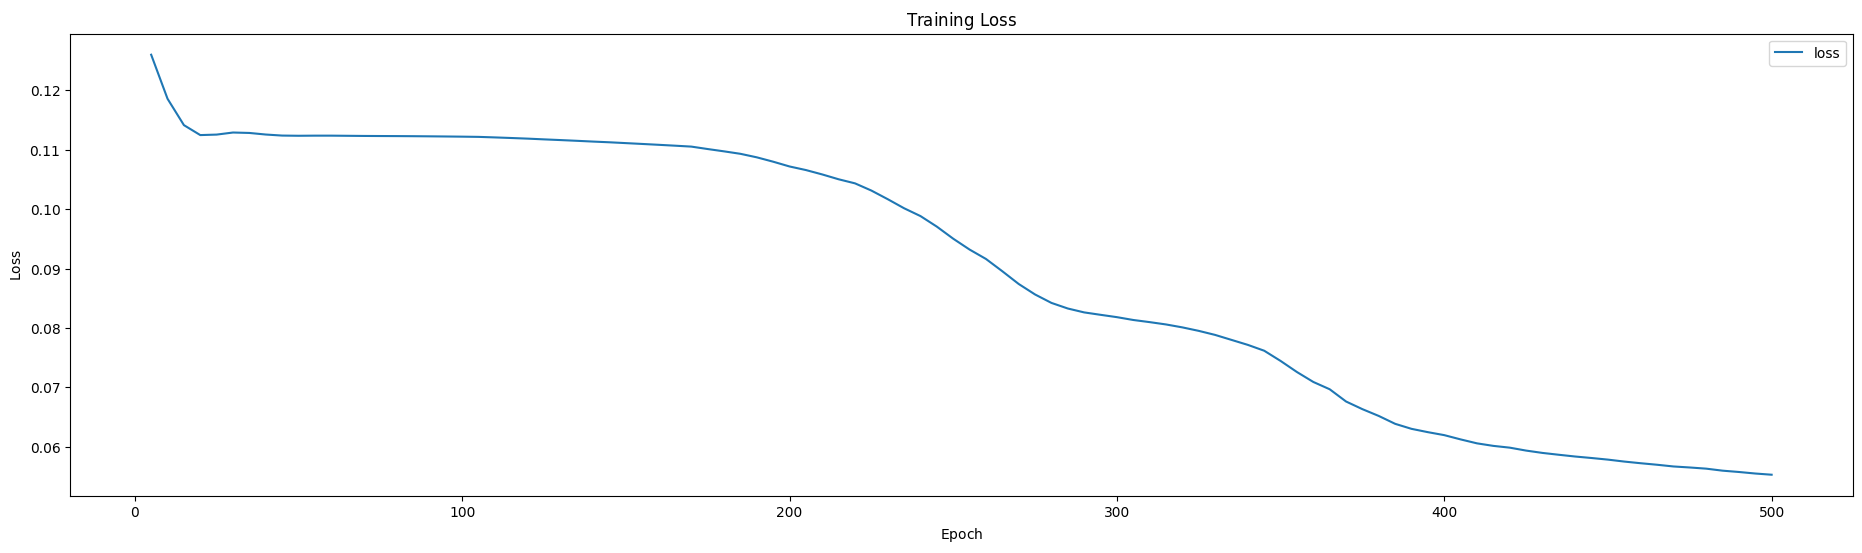

In [13]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="loss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss.png", dpi=300, bbox_inches="tight") ;

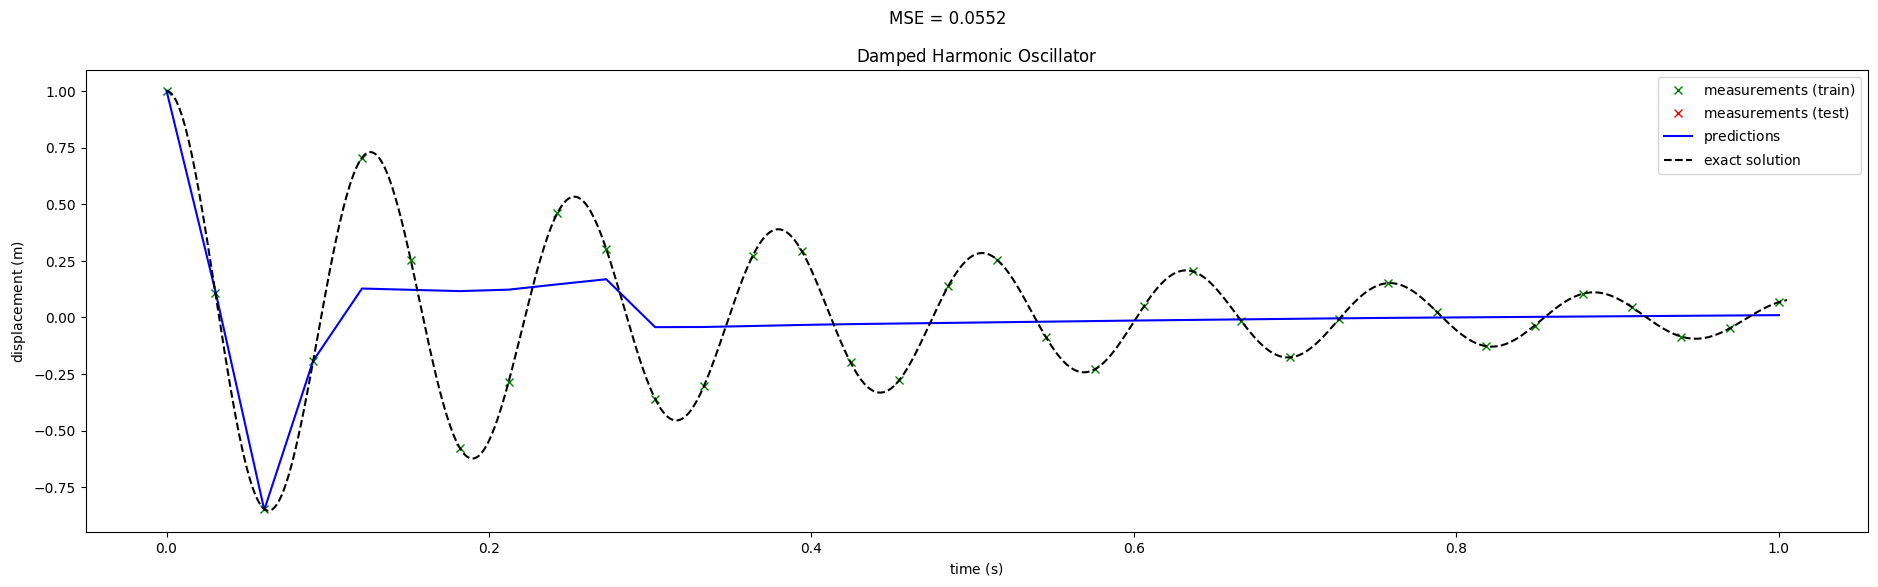

In [14]:
X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1)).detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 50").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    min_max_scaler.transform(t.reshape(-1, 1)), 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions.png", dpi=300, bbox_inches="tight") ;

## regularization & hyperparameters tuning

In [15]:
x_train = X.query("time <= 30")[["time"]].copy()
y_train = X.query("time <= 30")[["displacement"]].copy()

x_test = X.query("time > 30 and time <= 50")[["time"]].copy()
y_test = X.query("time > 30 and time <= 50")[["displacement"]].copy()

In [19]:
def hparam_objective(x_train:pd.DataFrame, y_train:pd.DataFrame, trial:optuna.trial.Trial):
    chunk = int(0.7 * x_train.shape[0])
    xt = x_train.iloc[:chunk,:][["time"]].copy()
    xh = x_train.iloc[chunk:,:][["time"]].copy()
    yt = y_train.iloc[:chunk,:][["displacement"]].copy()
    yh = y_train.iloc[chunk:,:][["displacement"]].copy()

    x_train = torch.tensor(xt["time"].values).float().unsqueeze(1)
    y_train = torch.tensor(yt["displacement"].values).float().unsqueeze(1)

    x_test = torch.tensor(xh["time"].values).float().unsqueeze(1)
    # y_test = torch.tensor(yh["displacement"].values).float().unsqueeze(1)

    torch.manual_seed(33)
    hparam_grid = {
        'n_layers': trial.suggest_int("n_layers", 2, 10),
        'n_neurons': trial.suggest_int("n_neurons", 2, 100),
        'activation': trial.suggest_categorical("activation", [nn.ReLU, nn.Tanh]),
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-1),
        'num_epochs': trial.suggest_categorical("num_epochs", [100, 500, 1000, 5000]),
        'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-1)
    }

    architecture = [1] + [hparam_grid["n_neurons"] for _ in range(hparam_grid["n_layers"])] + [1]

    model = MultiLayerPerceptronRegressor(architecture, hparam_grid["activation"])
    optimizer = optim.Adam(model.parameters(), lr=hparam_grid["learning_rate"], weight_decay=hparam_grid["weight_decay"])
    criterion = nn.MSELoss()

    for _ in range(hparam_grid["num_epochs"]):
        # forward
        y_train_hat = model(x_train)
        loss = criterion(y_train_hat, y_train)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    yt_hat = model(x_train).detach().numpy()
    yh_hat = model(x_test).detach().numpy()

    metric_1 = r2_score(yt, yt_hat) #+ np.mean(1.0 * (np.exp(-10.0 * yt_hat**2)))
    metric_2 = r2_score(yh, yh_hat) #+ np.mean(1.0 * (np.exp(-10.0 * yh_hat**2)))

    return metric_2, abs(metric_2 - metric_1)


In [20]:
study = optuna.create_study(directions=['maximize', 'minimize'])

[I 2023-10-21 07:06:51,175] A new study created in memory with name: no-name-84e59862-9889-4275-8796-161fca020c9f


In [21]:
study.optimize(
    functools.partial(
        hparam_objective,
        x_train,
        y_train
    ), 
    n_trials = 10
)

/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.Tanh'> which is of type type.
  warnings.warn(message)
[I 2023-10-21 07:07:00,430] Trial 0 finished with values: [-0.14097883886090945, 0.14096961648722983] and parameters: {'n_layers': 5, 'n_neurons': 58, 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'learning_rate': 0.040377842740098736, 'num_epochs': 5000, 'weight_decay': 0.08877403233982852}. 
/home/dusoudeth/Documentos/github/pin

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_activation,params_learning_rate,params_n_layers,params_n_neurons,params_num_epochs,params_weight_decay,system_attrs_nsga2:generation,state
7,7,-0.136367,0.136347,2023-10-21 07:07:10.785765,2023-10-21 07:07:10.889194,0 days 00:00:00.103429,<class 'torch.nn.modules.activation.Tanh'>,0.028358,4,97,100,0.066219,0,COMPLETE
0,0,-0.140979,0.140970,2023-10-21 07:06:55.096949,2023-10-21 07:07:00.430660,0 days 00:00:05.333711,<class 'torch.nn.modules.activation.Tanh'>,0.040378,5,58,5000,0.088774,0,COMPLETE
4,4,-0.141007,0.140998,2023-10-21 07:07:05.079130,2023-10-21 07:07:05.622880,0 days 00:00:00.543750,<class 'torch.nn.modules.activation.ReLU'>,0.030269,6,20,500,0.088508,0,COMPLETE
8,8,-0.141947,0.141939,2023-10-21 07:07:10.889774,2023-10-21 07:07:12.227393,0 days 00:00:01.337619,<class 'torch.nn.modules.activation.Tanh'>,0.005566,8,5,1000,0.079561,0,COMPLETE
5,5,-0.142381,0.142375,2023-10-21 07:07:05.623477,2023-10-21 07:07:10.487130,0 days 00:00:04.863653,<class 'torch.nn.modules.activation.Tanh'>,0.071866,4,100,5000,0.075462,0,COMPLETE
1,1,-0.142581,0.142574,2023-10-21 07:07:00.431252,2023-10-21 07:07:03.403915,0 days 00:00:02.972663,<class 'torch.nn.modules.activation.ReLU'>,0.054311,2,99,5000,0.074139,0,COMPLETE
2,2,-0.144044,0.144040,2023-10-21 07:07:03.404651,2023-10-21 07:07:03.983823,0 days 00:00:00.579172,<class 'torch.nn.modules.activation.ReLU'>,0.078318,2,74,1000,0.059980,0,COMPLETE
9,9,-0.149540,0.149540,2023-10-21 07:07:12.228096,2023-10-21 07:07:12.403912,0 days 00:00:00.175816,<class 'torch.nn.modules.activation.Tanh'>,0.008668,10,28,100,0.018949,0,COMPLETE
3,3,-0.149565,0.149565,2023-10-21 07:07:03.984394,2023-10-21 07:07:05.078539,0 days 00:00:01.094145,<class 'torch.nn.modules.activation.ReLU'>,0.093258,5,90,1000,0.010726,0,COMPLETE
6,6,-0.154348,0.154348,2023-10-21 07:07:10.487729,2023-10-21 07:07:10.785181,0 days 00:00:00.297452,<class 'torch.nn.modules.activation.Tanh'>,0.064230,2,81,500,0.011730,0,COMPLETE


{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'learning_rate': 0.028358005409762566,
 'n_layers': 4,
 'n_neurons': 97,
 'num_epochs': 100,
 'weight_decay': 0.0662194614908352}
[-0.13636740949707837, 0.1363472011030855]


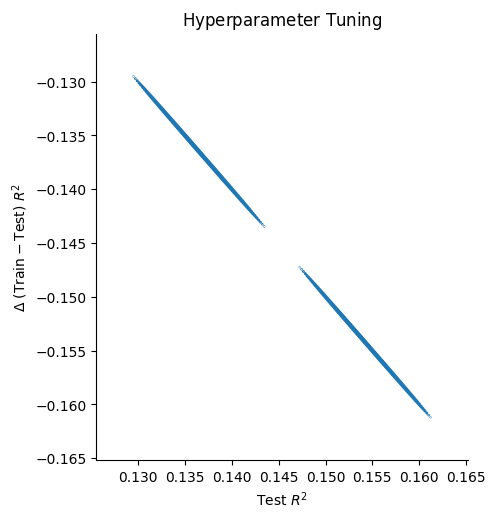

In [23]:
hparam_df = study.trials_dataframe()

sns.displot(
    hparam_df,
    x="values_1",
    y="values_0",
    kind="kde",
)
plt.title(r"$\mathrm{Hyperparameter}$ $\mathrm{Tuning}$")
plt.xlabel(r"$\mathrm{Test}$ $R^2$")
plt.ylabel(r"$\Delta$ ($\mathrm{Train-Test}$) $R^2$")

display(hparam_df.sort_values(by="values_0", ascending=False))
user_pick_index = 7

hparam_dict = study.get_trials()[user_pick_index].params

pprint.pprint(hparam_dict)
pprint.pprint(study.get_trials()[user_pick_index].values)

epoch [00500/00100] loss: 0.1124
epoch [01000/00100] loss: 0.1124
epoch [01500/00100] loss: 0.1124
epoch [02000/00100] loss: 0.1124
epoch [02500/00100] loss: 0.1124
epoch [03000/00100] loss: 0.1124
epoch [03500/00100] loss: 0.1124
epoch [04000/00100] loss: 0.1124
epoch [04500/00100] loss: 0.1124
epoch [05000/00100] loss: 0.1124


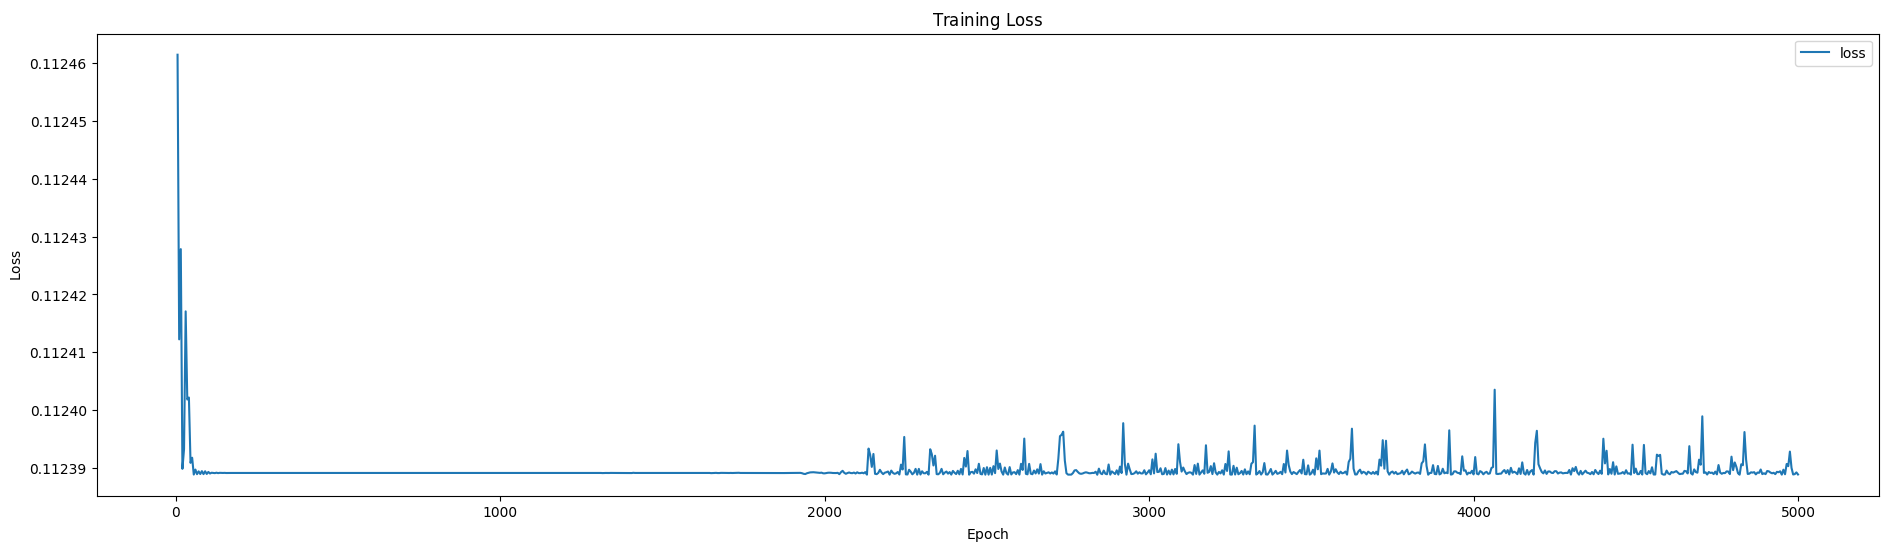

In [24]:
torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 30")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 30")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 30 and time <= 50")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 30 and time <= 50")["displacement"].values).float().unsqueeze(1).to(device)

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=hparam_dict["weight_decay"])
criterion = nn.MSELoss()

plot_loss_train = dict(epoch=[], loss=[])

for epoch in range(hparam_dict["num_epochs"]*50):
    # forward
    y_train_hat = model(x_train)
    loss = criterion(y_train_hat, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 500 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["loss"].append(loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="loss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_tuning.png", dpi=300, bbox_inches="tight") ;

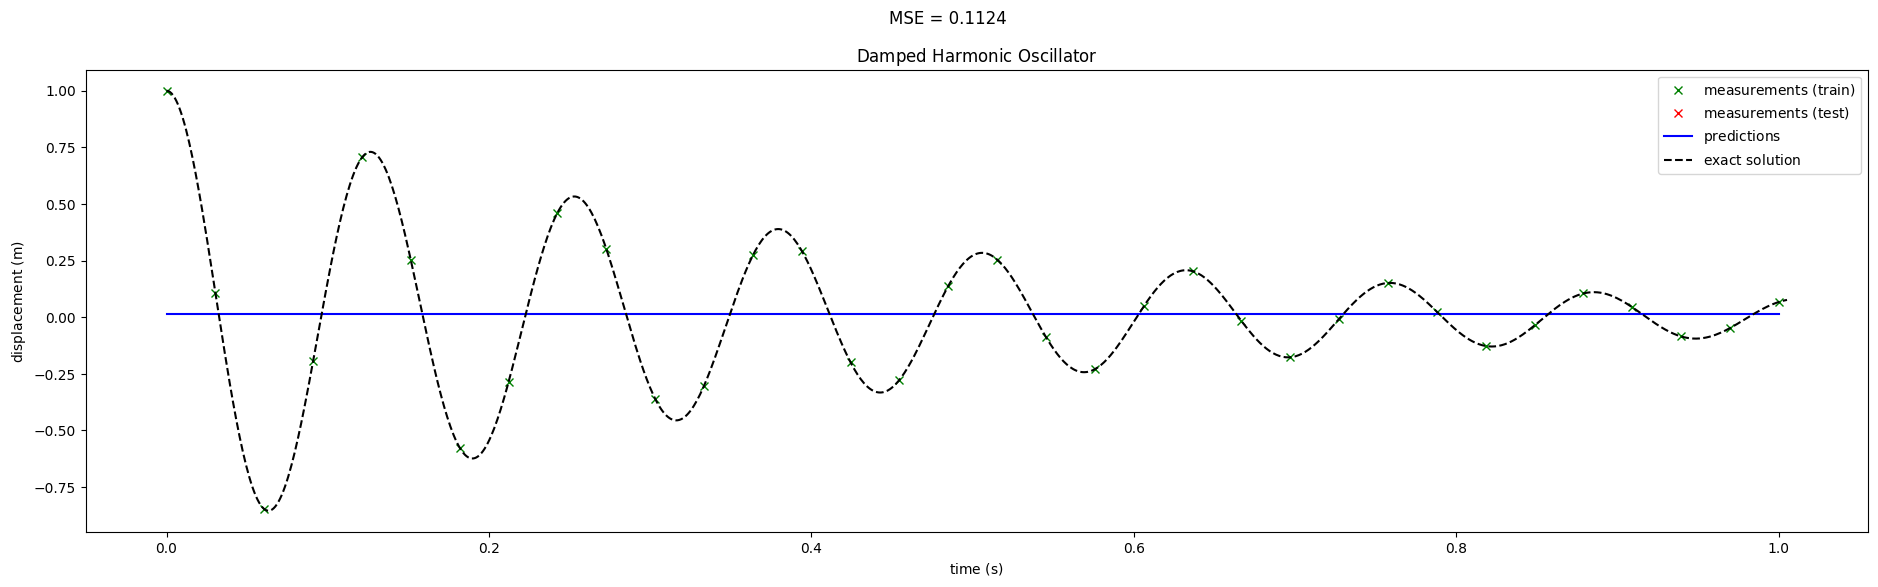

In [25]:
X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 100").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    min_max_scaler.transform(t.reshape(-1, 1)), 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_tuning.png", dpi=300, bbox_inches="tight") ;

# pinn

$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

In [56]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")

min_max_scaler = MinMaxScaler()
X["time"] = min_max_scaler.fit_transform(X["time"].values.reshape(-1, 1))

display(X)

,time,displacement,velocity,acceleration
0,0.000000,1.000000,0.000000,-1.000000
1,0.030303,0.106701,-0.926586,-0.014042
2,0.060606,-0.847175,-0.111879,0.858363
3,0.090909,-0.194060,0.783410,0.115719
4,0.121212,0.705190,0.190814,-0.724272
5,0.151515,0.252050,-0.650740,-0.186976
6,0.181818,-0.576071,-0.242684,0.600339
7,0.212121,-0.286335,0.530372,0.233298
8,0.242424,0.460883,0.272761,-0.488160
9,0.272727,0.301914,-0.423218,-0.259593


MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=1, bias=True)
  )
)
Data Loss: 0.207976, Physics Loss: 0.031062, x0 Loss: 0.677992, v0 Loss: 0.000000, Total Loss: 0.031062
Data Loss: 0.935966, Physics Loss: 0.800444, x0 Loss: 3.298670, v0 Loss: 0.010199, Total Loss: 0.800444
Data Loss: 0.183907, Physics Loss: 0.000055, x0 Loss

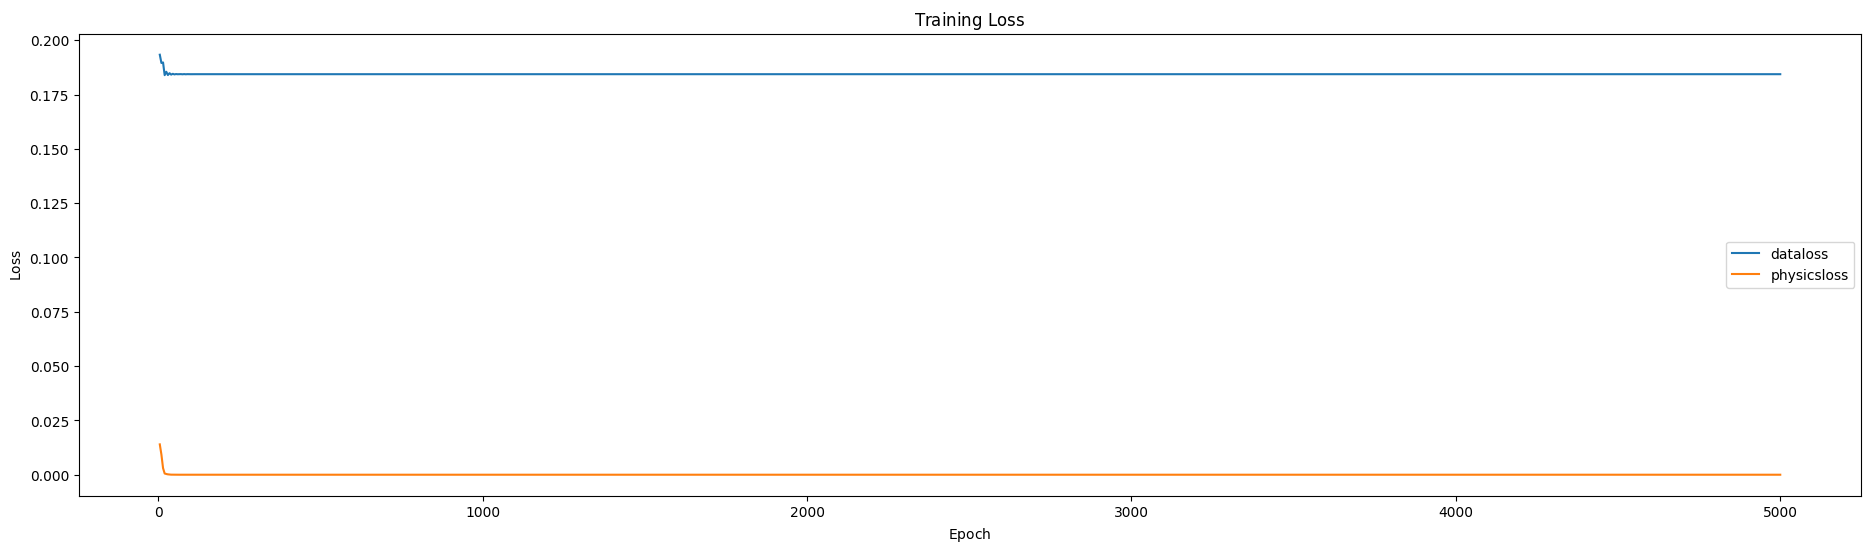

In [163]:
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 0.6")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 0.6")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 0.6 and time <= 1")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 0.6 and time <= 1")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 5e-2,
    'n_layers': 8,
    'n_neurons': 64,
    'num_epochs': 5000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=hparam_dict["weight_decay"])
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 1, 25).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_mu = torch.tensor(mu, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x_0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v_0, dtype=torch.float, requires_grad=False).to(device)

for epoch in range(hparam_dict["num_epochs"]):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = torch.mean((y_train_hat - y_train)**2)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

    _x0_loss = torch.mean((y_location_hat[0] - _x0)**2)
    _v0_loss = torch.mean((dydt[0] - _v0)**2)

    _diff_equation = _m*dy2dt2 + _mu*dydt + _k*y_location_hat
    
    physics_loss = torch.mean(_diff_equation**2)

    loss = physics_loss

    print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 250 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_pinn.png", dpi=300, bbox_inches="tight") ;

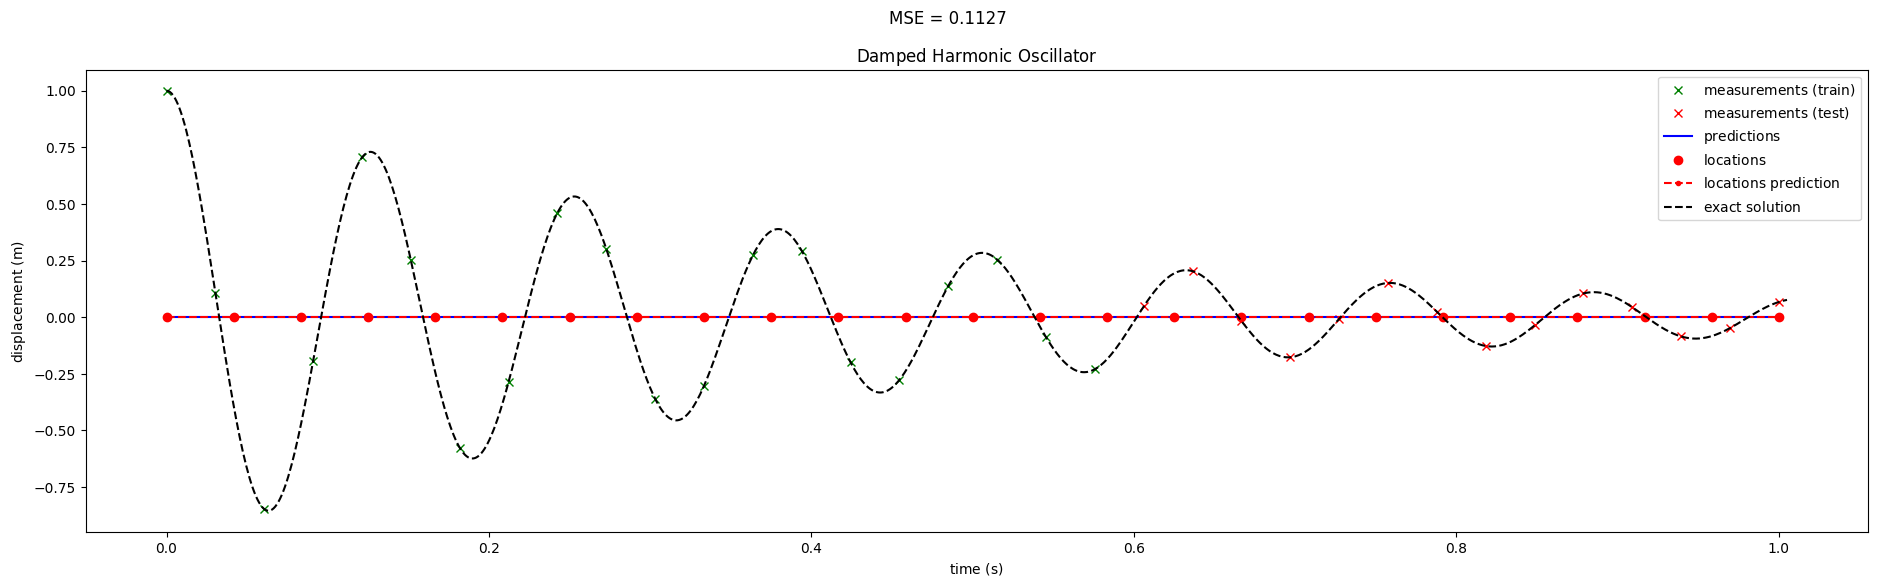

In [164]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 0.6").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 0.6 and time <= 1").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    min_max_scaler.transform(t.reshape(-1, 1)),
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_pinn.png", dpi=300, bbox_inches="tight") ;

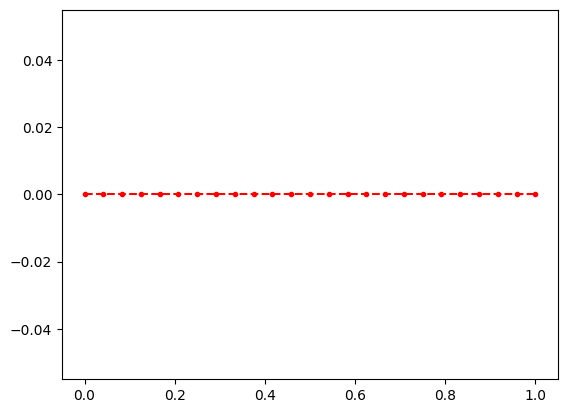

In [167]:
model.eval()
with torch.no_grad():
    plt.plot(
        _locations.cpu().detach().numpy().reshape(-1, 1),
        model(_locations).cpu().detach().numpy().reshape(-1), 
        c="r", linestyle="--", marker=".",
        label=r"$\text{locations prediction}$"
    )

In [111]:
X

,time,displacement,velocity,acceleration,y_hat
0,0.000000,1.000000,0.000000,-1.000000,0.528241
1,0.030303,0.106701,-0.926586,-0.014042,0.086097
2,0.060606,-0.847175,-0.111879,0.858363,-0.356046
3,0.090909,-0.194060,0.783410,0.115719,-0.194430
4,0.121212,0.705190,0.190814,-0.724272,0.703922
5,0.151515,0.252050,-0.650740,-0.186976,0.251313
6,0.181818,-0.576071,-0.242684,0.600339,-0.576224
7,0.212121,-0.286335,0.530372,0.233298,-0.286637
8,0.242424,0.460883,0.272761,-0.488160,0.460329
9,0.272727,0.301914,-0.423218,-0.259593,0.301280


In [198]:
_locations.cpu().detach().numpy().reshape(-1)

model(_locations).cpu().detach().numpy().reshape(-1)

array([ 0.99995923, -0.09352884, -0.80673015,  0.34794965,  0.5320889 ,
       -0.23421152, -0.17324647, -0.03106426,  0.04097931,  0.05977762,
        0.05307123,  0.03774813,  0.02175251,  0.00807196, -0.00262131,
       -0.01057975, -0.01633093, -0.02041033, -0.02326861, -0.02525549,
       -0.02663034, -0.0275757 , -0.02822517, -0.0286701 , -0.02897567,
       -0.02918404, -0.02932677, -0.02942353, -0.02949032, -0.0295358 ],
      dtype=float32)

.